In [1]:
from colpali_engine.models.qwen2_5.colqwen2_5.modeling_colqwen2_5 import ColQwen2_5
from colpali_engine.models.qwen2_5.colqwen2_5.processing_colqwen2_5 import ColQwen2_5_Processor

from datasets import load_dataset, concatenate_datasets
from colpali_engine.collators.visual_retriever_collator import VisualRetrieverCollator
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import numpy
from sklearn.manifold import TSNE
from transformers import Qwen2_5_VLProcessor, Qwen2_5_VLForConditionalGeneration

/home/user/colpali/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processor = ColQwen2_5_Processor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")
device = "cuda"
model= ColQwen2_5.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", 
    torch_dtype="bfloat16", 
    attn_implementation="flash_attention_2",
    device_map=device
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
Some weights of ColQwen2_5 were not initialized from the model checkpoint at Qwen/Qwen2.5-VL-3B-Instruct and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
processor = Qwen2_5_VLProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")
device = "cuda"
model= Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", 
    torch_dtype="bfloat16", 
    attn_implementation="flash_attention_2",
    device_map=device
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


In [3]:
print(len(model.model.layers))

# model.model.layers.pop(slice(18, None, 1))
# print(len(model.model.layers))

36


In [4]:
healthcare = load_dataset("vidore/syntheticDocQA_healthcare_industry_test", num_proc=40, split="test")
gov_reports = load_dataset("vidore/syntheticDocQA_government_reports_test", num_proc=40, split="test")
energy = load_dataset("vidore/syntheticDocQA_energy_test", num_proc=40, split="test")
arxiv = load_dataset("vidore/arxivqa_test_subsampled", num_proc=40, split="test")
shift = load_dataset("vidore/shiftproject_test", num_proc=40, split="test")

In [5]:
dataset = concatenate_datasets([
    healthcare.select([*range(300)]),
    gov_reports.select([*range(300)]),
    energy.select([*range(300)]),
    arxiv.select([*range(300)]),
    shift.select([*range(300)]),
])
target_names = ["healthcare", "gov_reports", "energy", "arxiv", "shift"]
targets = numpy.concat(
    (numpy.array([0] * 300),
    numpy.array([1] * 300),
    numpy.array([2] * 300),
    numpy.array([3] * 300),
    numpy.array([4] * 300)),
    axis=0
)

In [6]:
dataset = dataset.select([10])

In [6]:
collator = VisualRetrieverCollator(processor)
batch_size = 64
passage_embeddings = []
for i in tqdm(range(0, len(dataset), batch_size)):
    examples = dataset.select([*range(i, min(i+batch_size, len(dataset)))])
    batch = collator(examples)
    with torch.no_grad():
        emb_batch = model(
            **{
                k[4:]: v.to(device)
                for k, v in batch.items()
                if k.startswith("doc")
            }
        )
        passage_embeddings.extend(list(torch.unbind(emb_batch.to("cpu"))))


  0%|          | 0/24 [00:00<?, ?it/s]

(672, 868)
36


  4%|▍         | 1/24 [00:13<04:59, 13.02s/it]

(672, 868)
36


  8%|▊         | 2/24 [00:24<04:21, 11.89s/it]

(672, 868)
36


 12%|█▎        | 3/24 [00:35<04:01, 11.51s/it]

(672, 868)
36


 17%|█▋        | 4/24 [00:46<03:46, 11.34s/it]

(644, 896)
36


 21%|██        | 5/24 [00:57<03:35, 11.34s/it]

(896, 644)
36


 25%|██▌       | 6/24 [01:08<03:24, 11.35s/it]

(868, 672)
36


 29%|██▉       | 7/24 [01:19<03:10, 11.21s/it]

(868, 672)
36


 33%|███▎      | 8/24 [01:31<02:59, 11.19s/it]

(672, 868)
36


 38%|███▊      | 9/24 [01:42<02:47, 11.20s/it]

(672, 868)
36


 42%|████▏     | 10/24 [01:53<02:36, 11.20s/it]

(672, 868)
36


 46%|████▌     | 11/24 [02:04<02:25, 11.20s/it]

(672, 868)
36


 50%|█████     | 12/24 [02:15<02:14, 11.21s/it]

(672, 868)
36


 54%|█████▍    | 13/24 [02:27<02:03, 11.22s/it]

(672, 868)
36


 58%|█████▊    | 14/24 [02:38<01:52, 11.25s/it]

(672, 868)
36


 62%|██████▎   | 15/24 [02:47<01:36, 10.68s/it]

(1092, 532)
36


 67%|██████▋   | 16/24 [02:57<01:22, 10.36s/it]

(784, 756)
36


 71%|███████   | 17/24 [03:07<01:11, 10.19s/it]

(952, 588)
36


 75%|███████▌  | 18/24 [03:16<01:00, 10.05s/it]

(924, 616)
36


 79%|███████▉  | 19/24 [03:26<00:50, 10.04s/it]

(644, 896)
36


 83%|████████▎ | 20/24 [03:38<00:41, 10.39s/it]

(644, 896)
36


 88%|████████▊ | 21/24 [03:49<00:32, 10.68s/it]

(644, 896)
36


 92%|█████████▏| 22/24 [04:00<00:21, 10.89s/it]

(644, 896)
36


 96%|█████████▌| 23/24 [04:12<00:11, 11.02s/it]

(644, 896)
36


100%|██████████| 24/24 [04:17<00:00, 10.71s/it]


In [7]:
passage_embeddings= [emb.mean(dim=0) for emb in passage_embeddings]
passage_embeddings=torch.stack(passage_embeddings).to(dtype=torch.float)
print(passage_embeddings.shape)

torch.Size([1500, 2048])


In [ ]:
from colpali_engine.compression.token_pooling import HierarchicalTokenPooler
import random



img = dataset[0]["image"]
img = processor.smart_resize(img)
max_tokens = img.size[0] * img.size[1] // 28 // 28
print(img.size)
plt.figure(figsize=(12, 9),)
plt.imshow(img)

token_pooler = HierarchicalTokenPooler(pool_factor=150)
print(passage_embeddings[0].shape)
pooled_embeddigs = token_pooler.pool_embeddings(passage_embeddings, return_dict=True)
print(pooled_embeddigs.cluster_id_to_indices)

mapping = numpy.zeros((img.size[1], img.size[0]))
rows = mapping.shape[0] // 28
print("mapping:", mapping.shape)
mapping = mapping.reshape((28, -1))
print("mapping:", mapping.shape)

for cluster_id, indices in pooled_embeddigs.cluster_id_to_indices[0].items():
    indices = indices[0].tolist()
    # discard prefix tokens
    indices = [index - 4 for index in indices]
    # discard suffix tokens
    indices = [index for index in indices if index < max_tokens]
    if not indices:
        continue
    filler = random.randint(0, max_tokens - 1)
    print(indices)
    for index in indices:
        mapping[:, index * 28: (index + 1) * 28] = filler

mapping=numpy.split(mapping, axis=1, indices_or_sections=rows)
mapping = numpy.concat(mapping, axis=0)
print(dataset[0]["query"])

plt.imshow(mapping, alpha=0.5)





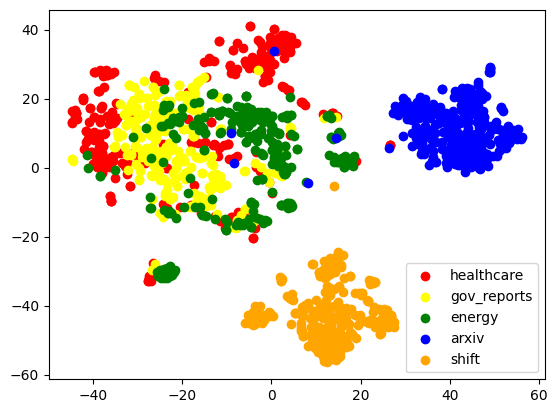

In [8]:

passage_low_dim = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=30
).fit_transform(passage_embeddings)
colors = ["red", "yellow", "green", "blue", "orange"]
fig, ax = plt.subplots()
for index, target_name in enumerate(target_names):
    passages_of_target = passage_low_dim[numpy.where(targets == index)]
    ax.scatter(
        x=passages_of_target[:, 0],
        y=passages_of_target[:, 1],
        c=colors[index],
        label=target_name,
    )
ax.legend()
plt.show()